In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import *
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import os
import pandas as pd

In [2]:
m = Model('POD')

# Indices for residential areas
area = range(42)

# Indices for POD sites
POD = range(47)

# Indices for scenarios
scenarios = range(3)

# POD Names
pod_names = np.genfromtxt("pod_names.csv", dtype= None, delimiter=',', encoding="utf8")

# School district names
sd_names = np.genfromtxt("sd_names.csv",  dtype= None, delimiter=',', encoding="utf8")

# Annual budget constraint is $13m
B = 13000000

## Read the capacity file and store it in capacity variable 
capacity = np.genfromtxt("capacity.csv", dtype=int, delimiter=',')

## Read the covid case file and store it in covid variable 
covid = np.genfromtxt("covid.csv", dtype=int, delimiter=',')

## Read the probs file and store it in p variable 
p = np.genfromtxt("probs.csv", dtype=float, delimiter=',', encoding='utf-8-sig')

## Read the number of households file and store it in households variable 
households = np.genfromtxt("households.csv", dtype=int, delimiter=',')

## Read the number of population file and store it in households variable 
population = np.genfromtxt("population.csv", dtype=int, delimiter=',', encoding='utf-8-sig')

# Read the distance file and store it into distance variable
distance = np.genfromtxt("distance.csv", dtype=float, delimiter=',')

# Read the fixed cost file and store it into fc variable
fc = np.genfromtxt("fc.csv", dtype=int, delimiter=',')

# Store the variable cost in vc variable
vc = 138

# Weights for multi-objective weight-based approach
alpha_values = [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999, 1]
first_obj = np.zeros([len(alpha_values), 2])

Using license file C:\Users\preme\gurobi.lic
Academic license - for non-commercial use only


In [3]:
###Set up decision variables 

# Whether POD site j is open
x = m.addVars(POD, vtype = GRB.BINARY)

# Whether residential area is assigned to POD site j
y = m.addVars(area, POD, vtype = GRB.BINARY)

# Number of people served by the POD site j under scenario s
N = m.addVars(POD, scenarios, lb = 0.0, vtype = GRB.INTEGER)

# Create a 1 by 1 vector to store the max distance
z = m.addVars(area, 1, lb = 0) #Create a 1 by 1 vector. 

# Create a mul variable to store the composite 
mul = m.addVars(area, POD, vtype = GRB.BINARY)

In [4]:
###Set up Objective 1 for minimizing the total/weighted travel distance of the households + fixed/operational costs
distancetotal = LinExpr() # total distance part of the objective function
distancetotal += sum(sum(distance[i, j] * y[i, j] * households[i] for i in area)for j in POD)

maxdistance = LinExpr() # total distance part of the objective function
maxdistance += z.sum()

fixedcost = LinExpr() # fixed cost part of the objective function
fixedcost += sum(x[j] * fc[j] for j in POD)

variablecost = LinExpr() # variable cost part of the objective function
variablecost += sum(sum(p[i,s] * (sum(sum(vc * mul[i,j] * N[j,s] for i in area)for j in POD)) for i in area) for s in scenarios)

In [5]:
for iteration in range(len(alpha_values)):
    alpha = alpha_values[iteration]
    m.setObjective(alpha*(distancetotal) + (1-alpha)*(fixedcost + variablecost), GRB.MINIMIZE)
    
    # Shelter site capacity constraint
    for j in POD:
        m.addConstr(sum(y[i, j] * households[i] for i in area) <= capacity[j] * x[j])

    # All residential areas are assigned to one POD site constraint
    for i in area:
        m.addConstr(sum(y[i, j] for j in POD) == 1)

    # Budget Constraint
    for s in scenarios:
         m.addConstr(sum(fc[j] * x[j] for j in POD) + sum(p[i,s] * (sum(sum(vc * mul[i,j] * N[j,s] for i in area)for j in POD)) for i in area) <= B)

    for i in area:
        for j in POD:
            m.addConstr(mul[i,j] == x[i] * y[i, j])

    for i in area:
        for j in POD:
             m.addConstr(z.sum() >= distance[i, j] * y[i, j])

    # Solve
    m.optimize()
    
    # Print optimal total distance, total cost
    print ("Total Weighted Distance: ", distancetotal.getValue())
    print ("Total Cost: ", fixedcost.getValue() + variablecost.getValue())
    print ("Max Travel Distance: ", maxdistance.getValue())
    
    first_obj[iteration, 0] = distancetotal.getValue()
    first_obj[iteration, 1] = fixedcost.getValue()+variablecost.getValue()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 2063 rows, 4178 columns and 88877 nonzeros
Model fingerprint: 0xcca19678
Model has 5922 quadratic objective terms
Model has 1977 quadratic constraints
Variable types: 42 continuous, 4136 integer (3995 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  QMatrix range    [1e+00, 6e+02]
  QLMatrix range   [1e+00, 1e+06]
  Objective range  [3e+05, 1e+06]
  QObjective range [3e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+07, 1e+07]
Presolve removed 1974 rows and 136 columns
Presolve time: 0.03s
Presolved: 19362 rows, 23312 columns, 56071 nonzeros
Presolved model has 11562 SOS constraint(s)
Variable types: 0 continuous, 23312 integer (11609 binary)
Found heuristic solution: objective 4089656.0000

Root relaxation: objective 9.603458e+05, 7391 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Ex

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1888255.03    0   51 2443701.32 1888255.03  22.7%     -    1s
H    0     0                    2329707.8800 1888255.03  18.9%     -    1s
     0     0 2040673.73    0   64 2329707.88 2040673.73  12.4%     -    1s
     0     0 2040673.73    0   24 2329707.88 2040673.73  12.4%     -    1s
     0     0 2042626.07    0   43 2329707.88 2042626.07  12.3%     -    1s
H    0     0                    2229950.6000 2042626.07  8.40%     -    1s
     0     0 2121869.66    0   57 2229950.60 2121869.66  4.85%     -    1s
     0     0 2121869.66    0   24 2229950.60 2121869.66  4.85%     -    2s
     0     0 2121869.66    0   34 2229950.60 2121869.66  4.85%     -    2s
     0     0 2121869.66    0   53 2229950.60 2121869.66  4.85%     -    2s
     0     0 2122262.92    0   43 2229950.60 2122262.92  4.83%     -    2s
     0     0 2122560.88    0   47 2229950.60 2122560.88  4.82%     -    2s
     0     0 2124854.7

H    0     0                    2587828.6000 2583442.92  0.17%     -    3s
     0     0 infeasible    0      2587828.60 2587828.60  0.00%     -    3s

Cutting planes:
  Gomory: 1
  Cover: 1

Explored 1 nodes (11707 simplex iterations) in 3.18 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 2.58783e+06 2.58858e+06 2.62345e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.587828600000e+06, best bound 2.587828600000e+06, gap 0.0000%
Total Weighted Distance:  3648377.5
Total Cost:  1880796.0
Max Travel Distance:  17.0
Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 16504 rows, 4178 columns and 711016 nonzeros
Model fingerprint: 0x742d8922
Model has 5922 quadratic objective terms
Model has 15816 quadratic constraints
Variable types: 42 continuous, 4136 integer (3995 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  QMatrix range    [1e+00, 6e+02]
  QLMatrix range   [1e+00, 1e+06]
  Objective range  [8e


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1631026.25    0  141 2745148.43 1631026.25  40.6%     -    1s
     0     0 2285663.49    0  159 2745148.43 2285663.49  16.7%     -    2s
     0     0 2285663.49    0   58 2745148.43 2285663.49  16.7%     -    2s
     0     0 2287818.27    0  105 2745148.43 2287818.27  16.7%     -    2s
     0     0 2288792.01    0  102 2745148.43 2288792.01  16.6%     -    2s
     0     0 2524861.85    0  142 2745148.43 2524861.85  8.02%     -    2s
     0     0 2524861.85    0  149 2745148.43 2524861.85  8.02%     -    2s
     0     0 2633788.22    0  118 2745148.43 2633788.22  4.06%     -    3s
     0     0 2686704.49    0  160 2745148.43 2686704.49  2.13%     -    3s
     0     0 2707745.49    0  147 2745148.43 2707745.49  1.36%     -    3s
     0     0 2711879.39    0  121 2745148.43 2711879.39  1.21%     -    3s
     0     0 2729512.90

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1285473.73    0  168 2484423.32 1285473.73  48.3%     -    4s
H    0     0                    2289527.8700 1285473.73  43.9%     -    4s
     0     0 2108971.20    0  189 2289527.87 2108971.20  7.89%     -    4s
     0     0 2108971.20    0   68 2289527.87 2108971.20  7.89%     -    5s
     0     0 2108971.20    0   92 2289527.87 2108971.20  7.89%     -    5s
     0     0 2125073.20    0   97 2289527.87 2125073.20  7.18%     -    5s
     0     0 2125124.61    0   99 2289527.87 2125124.61  7.18%     -    5s
     0     0 2224820.95    0   78 2289527.87 2224820.95  2.83%     -    5s
     0     0 2240005.95    0   63 2289527.87 2240005.95  2.16%     -    5s
     0     0 2270229.37    0   49 2289527.87 2270229.37  0.84%     -    5s
     0     0 2270229.37    0   19 2289527.87 2270229.37  0.84%     -    5s
     0     0 2279650.11    0    8 2289527.87 2279650.11  0.43%     -    5s
H    0     0          

     0     0 1051119.38    0  110 1298698.40 1051119.38  19.1%     -    4s
     0     0 1051119.38    0   30 1298698.40 1051119.38  19.1%     -    4s
     0     0 1051603.24    0   52 1298698.40 1051603.24  19.0%     -    4s
     0     0 1063458.12    0   41 1298698.40 1063458.12  18.1%     -    4s
     0     0 1235086.02    0   47 1298698.40 1235086.02  4.90%     -    4s
     0     0 1238404.19    0   43 1298698.40 1238404.19  4.64%     -    4s
     0     0 1272225.93    0   28 1298698.40 1272225.93  2.04%     -    5s
     0     0 1273854.35    0   10 1298698.40 1273854.35  1.91%     -    5s
     0     0 1290334.52    0   16 1298698.40 1290334.52  0.64%     -    5s
     0     0 1290635.11    0    4 1298698.40 1290635.11  0.62%     -    5s
     0     0 1290952.44    0   14 1298698.40 1290952.44  0.60%     -    5s
     0     0 1291863.22    0   14 1298698.40 1291863.22  0.53%     -    5s
     0     0 1291863.22    0    1 1298698.40 1291863.22  0.53%     -    5s
     0     0 1294530.86  

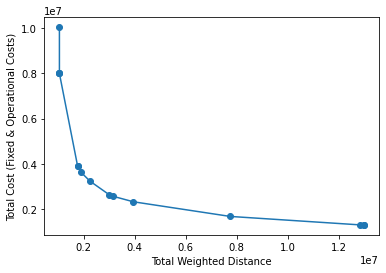

In [6]:
plt.scatter(first_obj[:,1],first_obj[:,0])
plt.xlabel('Total Weighted Distance')
plt.ylabel('Total Cost (Fixed & Operational Costs)')
plt.plot(first_obj[:,1],first_obj[:,0])

In [7]:
# Get School district POD Mapping to csv file
POD_list1 = []
area_list1 = []
match_list1 = []
for i in area :
    for j in POD:
        if y[i,j].x ==1:
            area_list1.append(i)
            POD_list1.append(j)

for a,b in zip(area_list1,POD_list1):
    match_list1.append([sd_names[a][0],sd_names[a][1],sd_names[a][2],pod_names[b][0],pod_names[b][1],pod_names[b][2]])
print(match_list1)

# opening the csv file in 'a+' mode 
file = open('obj1_result.csv', 'a+', newline ='') 
  
# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(match_list1) 

[['Avonworth', 40.53, -80.08, 'NORTHGATE JR SR HIGH', 40.50649194, -80.05625541], ['Baldwin', 40.39, -79.97, 'THOMAS JEFFERSON HIGH SCHOOL', 40.29790212, -79.93888717], ['Bethel Park', 40.33, -80.02, 'UPPER ST CLAIR HIGH SCHOOL', 40.33495744, -80.07023736], ['Brentwood', 40.37, -79.98, 'BALDWIN HIGH SCHOOL', 40.35565693, -79.97837687], ['Carlynton', 40.43, -80.1, 'CARLYNTON SENIOR HIGH', 40.42501989, -80.0963889], ['Chartiers Valley', 40.27, -80.19, 'SOUTH FAYETTE HIGH SCHOOL', 40.37532827, -80.16659223], ['Cornell', 39.96, -75.5, 'CORNELL JR/SR HIGH SCHOOL', 40.62034607, -79.85088348], ['Deer Lakes', 41.08, -75.41, 'DEER LAKES SENIOR HIGH', 40.62036583, -79.8505318], ['Duquesne', 40.37, -79.85, 'MCKEESPORT AREA HIGH SCHOOL', 40.34390052, -79.83077221], ['East Allegheny', 39.99, -75.11, 'MCKEESPORT AREA HIGH SCHOOL', 40.34390052, -79.83077221], ['Elizabeth Forward', 40.26, -79.9, 'SOUTH ALLEGHENY HIGH SCHOOL', 40.32381395, -79.86715373], ['Fox Chapel', 40.51, -79.88, 'RIVERVIEW SENIOR 

In [8]:
###Set up Model 2 to execute objective 2 for minimizing the max travel distance of the households + fixed/operational costs

m2 = Model('POD')

# Whether POD site j is open
x2 = m2.addVars(POD, vtype = GRB.BINARY)

# Whether residential area is assigned to POD site j
y2 = m2.addVars(area, POD, vtype = GRB.BINARY)

# Number of people served by the POD site j under scenario s
N2 = m2.addVars(POD, scenarios, lb = 0.0, vtype = GRB.INTEGER)

# Create a 1 by 1 vector to store the max distance
z2 = m2.addVars(area, 1, lb = 0) #Create a 1 by 1 vector. 

# Create a mul variable to store the composite
mul2 = m2.addVars(area, POD, vtype = GRB.BINARY)

In [9]:
distancetotal2 = LinExpr() # total distance part of the objective function
distancetotal2 += sum(sum(distance[i, j] * y2[i, j] * households[i] for i in area)for j in POD)

maxdistance2 = LinExpr() # total distance part of the objective function
maxdistance2 += z2.sum()

fixedcost2 = LinExpr() # fixed cost part of the objective function
fixedcost2 += sum(x2[j] * fc[j] for j in POD)

variablecost2 = LinExpr() # variable cost part of the objective function
variablecost2 += sum(sum(p[i,s] * (sum(sum(vc * mul2[i, j] * N2[j,s] for i in area)for j in POD)) for i in area) for s in scenarios)

m2.setObjective(maxdistance2, GRB.MINIMIZE)

In [10]:
# Max distance constraint
for i in area:
    for j in POD:
        m2.addConstr(z2.sum() >= distance[i, j] * y2[i, j])

# Shelter site capacity constraint
for j in POD:
    m2.addConstr(sum(y2[i, j] * households[i] for i in area) <= capacity[j] * x2[j])
    
# All residential areas are assigned to one POD site constraint
for i in area:
    m2.addConstr(sum(y2[i, j] for j in POD) == 1)
    
# Budget Constraint
for s in scenarios:
    m2.addConstr(sum(fc[j] * x2[j] for j in POD) + sum(p[i,s] * (sum(sum(vc * mul2[i,j] * N2[j,s] for i in area)for j in POD)) for i in area) <= B)

# Solve
m2.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 2063 rows, 4178 columns and 88877 nonzeros
Model fingerprint: 0x317fa9a3
Model has 3 quadratic constraints
Variable types: 42 continuous, 4136 integer (3995 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  QMatrix range    [2e+02, 6e+02]
  QLMatrix range   [3e+05, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+07, 1e+07]
Presolve removed 47 rows and 88 columns
Presolve time: 0.06s
Presolved: 13863 rows, 21856 columns, 43428 nonzeros
Presolved model has 11844 SOS constraint(s)
Variable types: 1 continuous, 21855 integer (9870 binary)
Found heuristic solution: objective 33.0000000
Found heuristic solution: objective 32.0000000

Root relaxation: objective 6.737665e-01, 6681 iterations, 0.08 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

In [11]:
# Print optimal max distance, total cost
print ("Total Weighted Distance: ", distancetotal2.getValue())
print ("Total Cost: ", fixedcost2.getValue() + variablecost2.getValue())
print ("Max Travel Distance: ", maxdistance2.getValue())

Total Weighted Distance:  1480661.8
Total Cost:  12753516.0
Max Travel Distance:  5.1000000000000005


In [12]:
# Get School district POD Mapping to csv file
POD_list2 = []
area_list2 = []
match_list2 = []
for i in area :
    for j in POD:
        if y2[i,j].x ==1:
            area_list2.append(i)
            POD_list2.append(j)

for a,b in zip(area_list2,POD_list2):
    match_list2.append([sd_names[a][0],sd_names[a][1],sd_names[a][2],pod_names[b][0],pod_names[b][1],pod_names[b][2]])
print(match_list2)

# opening the csv file in 'a+' mode 
file = open('obj2_result.csv', 'a+', newline ='') 
  
# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(match_list2) 

[['Avonworth', 40.53, -80.08, 'NORTH HILLS SENIOR HIGH', 40.52598486, -80.02487746], ['Baldwin', 40.39, -79.97, 'THOMAS JEFFERSON HIGH SCHOOL', 40.29790212, -79.93888717], ['Bethel Park', 40.33, -80.02, 'MT. LEBANON HIGH SCHOOL', 40.37550053, -80.05140779], ['Brentwood', 40.37, -79.98, 'BALDWIN HIGH SCHOOL', 40.35565693, -79.97837687], ['Carlynton', 40.43, -80.1, 'MT. LEBANON HIGH SCHOOL', 40.37550053, -80.05140779], ['Chartiers Valley', 40.27, -80.19, 'SOUTH FAYETTE HIGH SCHOOL', 40.37532827, -80.16659223], ['Cornell', 39.96, -75.5, 'MOON AREA HIGH SCHOOL', 40.51053939, -80.21952766], ['Deer Lakes', 41.08, -75.41, 'DEER LAKES SENIOR HIGH', 40.62036583, -79.8505318], ['Duquesne', 40.37, -79.85, 'DUQUESNE CITY SCHOOL (Elem)', 40.37035804, -79.8497946], ['East Allegheny', 39.99, -75.11, 'DUQUESNE CITY SCHOOL (Elem)', 40.37035804, -79.8497946], ['Elizabeth Forward', 40.26, -79.9, 'ELIZABETH FORWARD SR HIGH', 40.25572159, -79.85476708], ['Fox Chapel', 40.51, -79.88, 'RIVERVIEW SENIOR HIGH 

In [13]:
###Set up Model 3 to execute objective 3 for minimizing total distance 

m3 = Model('POD')

# Whether POD site j is open
x3 = m3.addVars(POD, vtype = GRB.BINARY)

# Whether residential area is assigned to POD site j
y3 = m3.addVars(area, POD, vtype = GRB.BINARY)

# Number of people served by the POD site j under scenario s
N3 = m3.addVars(POD, scenarios, lb = 0.0, vtype = GRB.INTEGER)

# Create a 1 by 1 vector to store the max distance
z3 = m3.addVars(area, 1, lb = 0) #Create a 1 by 1 vector. 

# Create a mul variable to store the composite
mul3 = m3.addVars(area, POD, vtype = GRB.BINARY)

In [14]:
distancetotal3 = LinExpr() # total distance part of the objective function
distancetotal3 += sum(sum(distance[i, j] * y3[i, j] * households[i] for i in area)for j in POD)

maxdistance3 = LinExpr() # total distance part of the objective function
maxdistance3 += z3.sum()

fixedcost3 = LinExpr() # fixed cost part of the objective function
fixedcost3 += sum(x3[j] * fc[j] for j in POD)

variablecost3 = LinExpr() # variable cost part of the objective function
variablecost3 += sum(sum(p[i,s] * (sum(sum(vc * mul3[i, j] * N3[j,s] for i in area)for j in POD)) for i in area) for s in scenarios)

m3.setObjective(distancetotal3, GRB.MINIMIZE)

In [15]:
# Max distance constraint
for i in area:
    for j in POD:
        m3.addConstr(z3.sum() >= distance[i, j] * y3[i, j])

# Shelter site capacity constraint
for j in POD:
    m3.addConstr(sum(y3[i, j] * households[i] for i in area) <= capacity[j] * x3[j])
    
# All residential areas are assigned to one POD site constraint
for i in area:
    m3.addConstr(sum(y3[i, j] for j in POD) == 1)
    
# Budget Constraint
for s in scenarios:
    m3.addConstr(sum(fc[j] * x3[j] for j in POD) + sum(p[i,s] * (sum(sum(vc * mul3[i,j] * N3[j,s] for i in area)for j in POD)) for i in area) <= B)

# Solve
m3.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 2063 rows, 4178 columns and 88877 nonzeros
Model fingerprint: 0x2b7929e4
Model has 3 quadratic constraints
Variable types: 42 continuous, 4136 integer (3995 binary)
Coefficient statistics:
  Matrix range     [2e-01, 3e+05]
  QMatrix range    [2e+02, 6e+02]
  QLMatrix range   [3e+05, 1e+06]
  Objective range  [2e+03, 4e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [1e+07, 1e+07]
Presolve removed 1974 rows and 89 columns
Presolve time: 0.03s
Presolved: 11936 rows, 21855 columns, 39574 nonzeros
Presolved model has 11844 SOS constraint(s)
Variable types: 0 continuous, 21855 integer (9870 binary)
Found heuristic solution: objective 2459416.5000

Root relaxation: objective 1.040884e+06, 4550 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

In [16]:
# Print optimal max distance, total cost
print ("Total Weighted Distance: ", distancetotal3.getValue())
print ("Total Cost: ", fixedcost3.getValue() + variablecost3.getValue())
print ("Max Travel Distance: ", maxdistance3.getValue())

Total Weighted Distance:  1298698.4000000001
Total Cost:  12966344.0
Max Travel Distance:  9.0


In [17]:
# Get School district POD Mapping to csv file
POD_list3 = []
area_list3 = []
match_list3 = []
for i in area :
    for j in POD:
        if y3[i,j].x ==1:
            area_list3.append(i)
            POD_list3.append(j)

for a,p in zip(area_list3,POD_list3):
    match_list3.append([sd_names[a][0],sd_names[a][1],sd_names[a][2],pod_names[p][0],pod_names[p][1],pod_names[p][2]])
print(match_list3)

# opening the csv file in 'a+' mode 
file = open('obj3_result.csv', 'a+', newline ='') 
  
# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(match_list3) 

[['Avonworth', 40.53, -80.08, 'NORTHGATE JR SR HIGH', 40.50649194, -80.05625541], ['Baldwin', 40.39, -79.97, 'THOMAS JEFFERSON HIGH SCHOOL', 40.29790212, -79.93888717], ['Bethel Park', 40.33, -80.02, 'UPPER ST CLAIR HIGH SCHOOL', 40.33495744, -80.07023736], ['Brentwood', 40.37, -79.98, 'BALDWIN HIGH SCHOOL', 40.35565693, -79.97837687], ['Carlynton', 40.43, -80.1, 'CARLYNTON SENIOR HIGH', 40.42501989, -80.0963889], ['Chartiers Valley', 40.27, -80.19, 'SOUTH FAYETTE HIGH SCHOOL', 40.37532827, -80.16659223], ['Cornell', 39.96, -75.5, 'CORNELL JR/SR HIGH SCHOOL', 40.62034607, -79.85088348], ['Deer Lakes', 41.08, -75.41, 'DEER LAKES SENIOR HIGH', 40.62036583, -79.8505318], ['Duquesne', 40.37, -79.85, 'MCKEESPORT AREA HIGH SCHOOL', 40.34390052, -79.83077221], ['East Allegheny', 39.99, -75.11, 'MCKEESPORT AREA HIGH SCHOOL', 40.34390052, -79.83077221], ['Elizabeth Forward', 40.26, -79.9, 'SOUTH ALLEGHENY HIGH SCHOOL', 40.32381395, -79.86715373], ['Fox Chapel', 40.51, -79.88, 'RIVERVIEW SENIOR 

In [18]:
distance_list1 = []
residents_list1 = []
distance_list2 = []
residents_list2 = []
distance_list3 = []
residents_list3 = []
for i in area:
    for j in POD:
            distance_list1.append(distance[i,j]*y[i, j].x)
            residents_list1.append(households[i]*y[i, j].x)
            distance_list2.append(distance[i,j]*y2[i, j].x)
            residents_list2.append(households[i]*y2[i, j].x)
            distance_list3.append(distance[i,j]*y3[i, j].x)
            residents_list3.append(households[i]*y3[i, j].x)

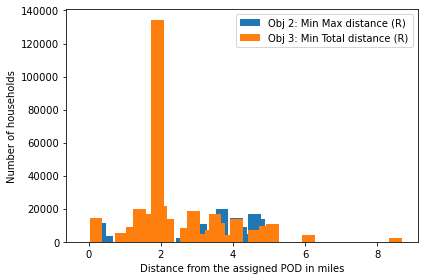

In [19]:
fig, ax = plt.subplots()
ax.bar(distance_list2, residents_list2, 0.35, label='Obj 2: Min Max distance (R)')
ax.bar(distance_list3, residents_list3, 0.35, label='Obj 3: Min Total distance (R)')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of households')
ax.set_xlabel('Distance from the assigned POD in miles')
ax.legend()
fig.tight_layout()

plt.show()

In [20]:
#total_weighted_distance_1 = distancetotal.getValue()
total_weighted_distance_2 =distancetotal2.getValue()
total_weighted_distance_3 =distancetotal3.getValue()

#total_cost_1 = fixedcost.getValue() + variablecost.getValue()
total_cost_2 = fixedcost2.getValue() + variablecost2.getValue()
total_cost_3 = fixedcost3.getValue() + variablecost3.getValue()

#max_distance1 = maxdistance.getValue()
max_distance2 = maxdistance2.getValue()
max_distance3 = maxdistance3.getValue()

In [21]:
total_weighted_distance = [total_weighted_distance_2, total_weighted_distance_3]
max_distance = [max_distance2, max_distance3]
total_cost = [('  $' + (str(round((total_cost_2/1000000),2))) + ' M'),\
                                                               ('  $' + (str(round((total_cost_3/1000000),2))) + ' M')]
model_name = ["Obj2: Min Max distance(R)","Obj3: Min Total distance(R)"]
result_df = pd.DataFrame({'Total_distance':total_weighted_distance,\
                         'Maximum_distance':max_distance,\
                          'Total_cost':total_cost,\
                         'Model_name':model_name})

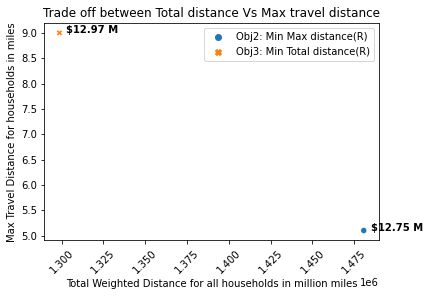

In [22]:
g = sns.scatterplot(x = result_df.Total_distance,y = result_df.Maximum_distance,\
                hue = result_df.Model_name, data = result_df,style ='Model_name')
plt.title("Trade off between Total distance Vs Max travel distance")
plt.xlabel("Total Weighted Distance for all households in million miles")
plt.ylabel("Max Travel Distance for households in miles")
plt.xticks(rotation=45)
plt.legend()
# g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
for line in range(0,result_df.shape[0]):
    g.text(result_df.Total_distance.iloc[line], result_df.Maximum_distance.iloc[line], result_df.Total_cost.iloc[line],\
        horizontalalignment='left', size='medium', color='black', weight='semibold')